# 🔍 Extraction de Relations Sémantiques avec spaCy

Ce notebook implémente un système d'extraction de triplets **(Sujet, Relation, Objet)** pour la construction de graphes de connaissances.

## 📋 Objectifs
- Extraire des relations sémantiques à partir d'entités nommées
- Utiliser l'analyse de dépendances syntaxiques de spaCy
- Générer des triplets au format JSON

## 📊 Dataset
- **Source** : `dataset.csv`
- **Colonnes** : `text`, `gliner_entities`
- **Taille** : 700 phrases annotées

In [20]:
# Imports
import pandas as pd
import json
import spacy
from typing import List, Dict, Tuple
from collections import defaultdict

print("✅ Bibliothèques importées avec succès")

✅ Bibliothèques importées avec succès


## 1️⃣ Chargement du Modèle spaCy

Nous utilisons le modèle `en_core_web_sm` pour l'analyse syntaxique en anglais.

In [21]:
# Charger le modèle spaCy
nlp = spacy.load("en_core_web_sm")

# Test rapide
doc = nlp("Aeneas traveled to Hades")
print("🔍 Analyse de dépendances:")
for token in doc:
    print(f"  {token.text:12} → {token.dep_:10} (head: {token.head.text})")

🔍 Analyse de dépendances:
  Aeneas       → nsubj      (head: traveled)
  traveled     → ROOT       (head: traveled)
  to           → prep       (head: traveled)
  Hades        → pobj       (head: to)


## 2️⃣ Fonctions Utilitaires

Définition des fonctions pour parser les entités et extraire les relations.

In [22]:
def parse_entities(entities_str: str) -> List[Dict]:
    """Parse la chaîne JSON des entités"""
    if pd.isna(entities_str) or entities_str == '[]':
        return []
    try:
        return json.loads(entities_str.replace("'", '"'))
    except:
        return []

print("✅ Fonction parse_entities définie")

✅ Fonction parse_entities définie


In [23]:
def extract_relation_from_dependency(doc, entity1, entity2) -> str:
    """Extrait la relation entre deux entités basée sur l'analyse de dépendances"""
    e1_tokens = [token for token in doc if entity1['start'] <= token.idx < entity1['end']]
    e2_tokens = [token for token in doc if entity2['start'] <= token.idx < entity2['end']]
    
    if not e1_tokens or not e2_tokens:
        return None
    
    e1_head = e1_tokens[0]
    e2_head = e2_tokens[0]
    
    # Cas 1: Relation sujet-verbe-objet
    for token in doc:
        if token.pos_ == "VERB":
            subjects = [child for child in token.children if child.dep_ in ["nsubj", "nsubjpass"]]
            objects = [child for child in token.children if child.dep_ in ["dobj", "pobj", "attr", "prep"]]
            
            if any(e1_head in s.subtree for s in subjects) and any(e2_head in o.subtree for o in objects):
                relation_parts = [token.lemma_]
                for child in token.children:
                    if child.dep_ == "prep" and any(e2_head in child.subtree for _ in [child]):
                        relation_parts.append(child.text)
                return "_".join(relation_parts)
    
    # Cas 2: Relation possessive
    for token in e1_tokens:
        if token.dep_ == "poss" and e2_head in token.head.subtree:
            return "possesses"
        if token.head == e2_head or e2_head.head == token:
            return token.dep_
    
    # Cas 3: Relation via préposition
    for token in doc:
        if token.pos_ == "ADP":
            if any(e1_head in token.head.subtree for _ in [token]) and any(e2_head in token.subtree for _ in [token]):
                return token.text
    
    return None

print("✅ Fonction extract_relation_from_dependency définie")

✅ Fonction extract_relation_from_dependency définie


In [24]:
def determine_relation_type(entity1_label: str, entity2_label: str, relation: str) -> str:
    """Détermine un type de relation sémantique plus précis"""
    if entity1_label == "person" and entity2_label == "location":
        if relation in ["travel", "go", "move", "visit"]:
            return "traveled_to"
        elif relation in ["born", "live"]:
            return "located_in"
        elif relation in ["rule", "govern"]:
            return "ruled"
    
    if entity1_label == "person" and entity2_label == "organization":
        if relation in ["work", "serve", "join"]:
            return "member_of"
        elif relation in ["found", "create", "establish"]:
            return "founded"
        elif relation in ["lead", "head", "direct"]:
            return "leads"
    
    return relation if relation else "related_to"

print("✅ Fonction determine_relation_type définie")

✅ Fonction determine_relation_type définie


## 3️⃣ Extraction de Triplets

Fonction principale pour extraire tous les triplets d'une phrase.

In [25]:
def extract_triplets_from_sentence(text: str, entities: List[Dict]) -> List[Dict]:
    """Extrait tous les triplets (Sujet, Relation, Objet) d'une phrase"""
    if not entities or len(entities) < 2:
        return []
    
    doc = nlp(text)
    triplets = []
    
    for i, entity1 in enumerate(entities):
        for entity2 in entities[i+1:]:
            relation = extract_relation_from_dependency(doc, entity1, entity2)
            
            if relation:
                semantic_relation = determine_relation_type(
                    entity1['label'], entity2['label'], relation
                )
                
                triplet = {
                    "subject": entity1['text'],
                    "subject_type": entity1['label'],
                    "relation": semantic_relation,
                    "object": entity2['text'],
                    "object_type": entity2['label'],
                    "confidence": min(entity1.get('score', 1.0), entity2.get('score', 1.0))
                }
                triplets.append(triplet)
            
            # Essayer dans l'autre sens
            relation_reverse = extract_relation_from_dependency(doc, entity2, entity1)
            if relation_reverse and relation_reverse != relation:
                semantic_relation = determine_relation_type(
                    entity2['label'], entity1['label'], relation_reverse
                )
                
                triplet = {
                    "subject": entity2['text'],
                    "subject_type": entity2['label'],
                    "relation": semantic_relation,
                    "object": entity1['text'],
                    "object_type": entity1['label'],
                    "confidence": min(entity1.get('score', 1.0), entity2.get('score', 1.0))
                }
                triplets.append(triplet)
    
    return triplets

print("✅ Fonction extract_triplets_from_sentence définie")

✅ Fonction extract_triplets_from_sentence définie


## 4️⃣ Test sur un Exemple

Testons l'extraction sur une phrase exemple.

In [26]:
# Exemple de phrase
example_text = "When Aeneas later traveled to Hades, he called to her ghost."
example_entities = [
    {'start': 5, 'end': 11, 'text': 'Aeneas', 'label': 'person', 'score': 0.97},
    {'start': 30, 'end': 35, 'text': 'Hades', 'label': 'location', 'score': 0.97}
]

# Extraction
triplets = extract_triplets_from_sentence(example_text, example_entities)

print("📊 Triplets extraits:")
for t in triplets:
    print(f"  ({t['subject']}) --[{t['relation']}]--> ({t['object']})")
    
print(f"\n✅ {len(triplets)} triplet(s) extrait(s)")

📊 Triplets extraits:
  (Aeneas) --[travel_to]--> (Hades)

✅ 1 triplet(s) extrait(s)


## 5️⃣ Traitement du Dataset Complet

Chargement et traitement de toutes les phrases du dataset.

In [27]:
# Charger le dataset
dataset_path = "dataset.csv"
df = pd.read_csv(dataset_path)

print(f"📁 Dataset chargé: {len(df)} phrases")
print(f"\nColonnes: {list(df.columns)}")
print(f"\nAperçu:")
df.head(3)

📁 Dataset chargé: 700 phrases

Colonnes: ['id', 'text', 'words', 'ner_tags', 'cleaned_text', 'lemmatized_text', 'gliner_entities', 'spacy_entities']

Aperçu:


,id,text,words,ner_tags,cleaned_text,lemmatized_text,gliner_entities,spacy_entities
0,en-doc5809-sent11,"When Aeneas later traveled to Hades , he calle...","['When', 'Aeneas', 'later', 'traveled', 'to', ...","[0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",when aeneas later traveled to hades he called ...,when aeneas later travel to hade he call to he...,"[{'start': 5, 'end': 11, 'text': 'Aeneas', 'la...",[]
1,en-doc6123-sent45,On 23 November 1969 he wrote to The Times news...,"['On', '23', 'November', '1969', 'he', 'wrote'...","[0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, ...",on 23 november 1969 he wrote to the times news...,on 23 november 1969 he write to the times news...,"[{'start': 20, 'end': 22, 'text': 'he', 'label...","[{'text': 'czechoslovakia', 'start': 99, 'end'..."
2,en-doc5831-sent40,Stephenson 's estimates and organising ability...,"['Stephenson', ""'s"", 'estimates', 'and', 'orga...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, ...",stephenson s estimates and organising ability ...,stephenson s estimate and organise ability pro...,"[{'start': 0, 'end': 10, 'text': 'Stephenson',...","[{'text': 'stephenson s', 'start': 0, 'end': 1..."


In [28]:
# Extraction sur tout le dataset
all_triplets = []
stats = defaultdict(int)

print("🔄 Traitement en cours...")

for idx, row in df.iterrows():
    if idx % 100 == 0:
        print(f"  Progression: {idx}/{len(df)} phrases")
    
    text = row['text']
    gliner_entities = parse_entities(row['gliner_entities'])
    triplets = extract_triplets_from_sentence(text, gliner_entities)
    
    for triplet in triplets:
        triplet['sentence_id'] = row['id']
        triplet['sentence'] = text
        all_triplets.append(triplet)
        stats[triplet['relation']] += 1

print(f"\n✅ Extraction terminée!")
print(f"📊 {len(all_triplets)} triplets extraits")

🔄 Traitement en cours...
  Progression: 0/700 phrases
  Progression: 100/700 phrases
  Progression: 200/700 phrases
  Progression: 300/700 phrases
  Progression: 400/700 phrases
  Progression: 500/700 phrases
  Progression: 600/700 phrases

✅ Extraction terminée!
📊 1579 triplets extraits


## 6️⃣ Statistiques et Visualisation

Analyse des résultats de l'extraction.

In [29]:
# Statistiques
print("="*60)
print("STATISTIQUES D'EXTRACTION")
print("="*60)
print(f"Total de phrases traitées: {len(df)}")
print(f"Total de triplets extraits: {len(all_triplets)}")
print(f"Moyenne de triplets par phrase: {len(all_triplets)/len(df):.2f}")
print(f"\nTypes de relations trouvées: {len(stats)}")

print("\nTop 10 des relations les plus fréquentes:")
for relation, count in sorted(stats.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {relation:20} : {count:4} occurrences")

STATISTIQUES D'EXTRACTION
Total de phrases traitées: 700
Total de triplets extraits: 1579
Moyenne de triplets par phrase: 2.26

Types de relations trouvées: 284

Top 10 des relations les plus fréquentes:
  in                   :  184 occurrences
  by                   :  113 occurrences
  to                   :  112 occurrences
  of                   :  110 occurrences
  conj                 :   88 occurrences
  pobj                 :   59 occurrences
  as                   :   55 occurrences
  with                 :   53 occurrences
  from                 :   49 occurrences
  possesses            :   47 occurrences


In [30]:
# Afficher quelques exemples
print("📋 Exemples de triplets extraits:\n")

for i, triplet in enumerate(all_triplets[:5], 1):
    print(f"{i}. ({triplet['subject']}) --[{triplet['relation']}]--> ({triplet['object']})")
    print(f"   Type: {triplet['subject_type']} → {triplet['object_type']}")
    print(f"   Confiance: {triplet['confidence']:.2f}")
    print(f"   Phrase: {triplet['sentence'][:80]}...")
    print()

📋 Exemples de triplets extraits:

1. (Aeneas) --[travel_to]--> (Hades)
   Type: person → location
   Confiance: 0.97
   Phrase: When Aeneas later traveled to Hades , he called to her ghost but she neither spo...

2. (he) --[write_to]--> (The Times newspaper)
   Type: person → organization
   Confiance: 0.39
   Phrase: On 23 November 1969 he wrote to The Times newspaper saying that the preparation ...

3. (Czechoslovakia) --[to]--> (The Times newspaper)
   Type: location → organization
   Confiance: 0.88
   Phrase: On 23 November 1969 he wrote to The Times newspaper saying that the preparation ...

4. (Locke) --[to]--> (board)
   Type: person → organization
   Confiance: 0.80
   Phrase: Stephenson 's estimates and organising ability proved to be inferior to those of...

5. (Locke) --[to]--> (Stephenson)
   Type: person → person
   Confiance: 0.88
   Phrase: Stephenson 's estimates and organising ability proved to be inferior to those of...



## 7️⃣ Sauvegarde des Résultats

Export des triplets au format JSON.

In [31]:
# Sauvegarder les résultats
output_path = "extracted_triplets.json"

with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(all_triplets, f, ensure_ascii=False, indent=2)

print(f"💾 Résultats sauvegardés dans: {output_path}")
print(f"📊 {len(all_triplets)} triplets exportés")

💾 Résultats sauvegardés dans: extracted_triplets.json
📊 1579 triplets exportés


## 8️⃣ Analytics Avancées du Graphe

Analyses graphiques avec NetworkX : Construction, Centralité, Communautés et Filtrage.

In [40]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# 1. Construction du Graphe Complet
G = nx.DiGraph()
for triplet in all_triplets:
    G.add_edge(triplet['subject'], triplet['object'], 
               relation=triplet['relation'])

print(f"📊 Graphe construit avec {G.number_of_nodes()} nœuds et {G.number_of_edges()} arêtes")

📊 Graphe construit avec 1037 nœuds et 1530 arêtes


In [41]:
# 2. Analyse de Centralité (Entités les plus importantes)
degree_cent = nx.degree_centrality(G)
top_nodes = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:10]

print("🌟 Top 10 des entités les plus connectées:")
for node, score in top_nodes:
    print(f"  {node:20} : score {score:.3f} ({G.degree(node)} connexions)")

🌟 Top 10 des entités les plus connectées:
  he                   : score 0.023 (24 connexions)
  Carlisle             : score 0.015 (16 connexions)
  France               : score 0.014 (15 connexions)
  publications         : score 0.014 (14 connexions)
  Persian Gulf         : score 0.012 (12 connexions)
  Chambersburg         : score 0.011 (11 connexions)
  Gettysburg           : score 0.011 (11 connexions)
  Susquehanna River    : score 0.011 (11 connexions)
  Germany              : score 0.011 (11 connexions)
  Joseph Locke         : score 0.011 (11 connexions)


In [42]:
# 3. Détection de Communautés (Groupes liés)
try:
    # Conversion en non-orienté pour la détection (Louvain)
    G_undirected = G.to_undirected()
    communities = list(nx.community.louvain_communities(G_undirected))
    
    print(f"🔍 {len(communities)} communautés détectées")
    print("\nPlus grandes communautés:")
    for i, comm in enumerate(sorted(communities, key=len, reverse=True)[:5], 1):
        print(f"  Communauté {i}: {len(comm)} nœuds (ex: {list(comm)[:5]}...)")
except Exception as e:
    print(f"Note: {e} (Nécessite scipy/networkx à jour)")

🔍 262 communautés détectées

Plus grandes communautés:
  Communauté 1: 40 nœuds (ex: ['Frankfurt', 'Péter Esterházy', 'Germany', 'king', 'reserve armored division']...)
  Communauté 2: 28 nœuds (ex: ['quick preparation boxes', 'South America', 'ceramics', 'standard line insurance companies', 'Magyar peasantry']...)
  Communauté 3: 26 nœuds (ex: ['David Sherlock', 'Stanley', 'Belsize Park', 'Skylark', 'Siena']...)
  Communauté 4: 26 nœuds (ex: ['Ahmad', 'Mughal Empire', 'Mashhad', 'Croatia', 'Bulgaria']...)
  Communauté 5: 25 nœuds (ex: ['problems', 'Matthew', 'Thierry', 'queen', 'She']...)


🎯 Sous-graphe filtré (degré >= 3): 466 nœuds


/var/folders/4t/v1dj_3b96158rglkv2ts2g8c0000gn/T/ipykernel_87205/2719571376.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


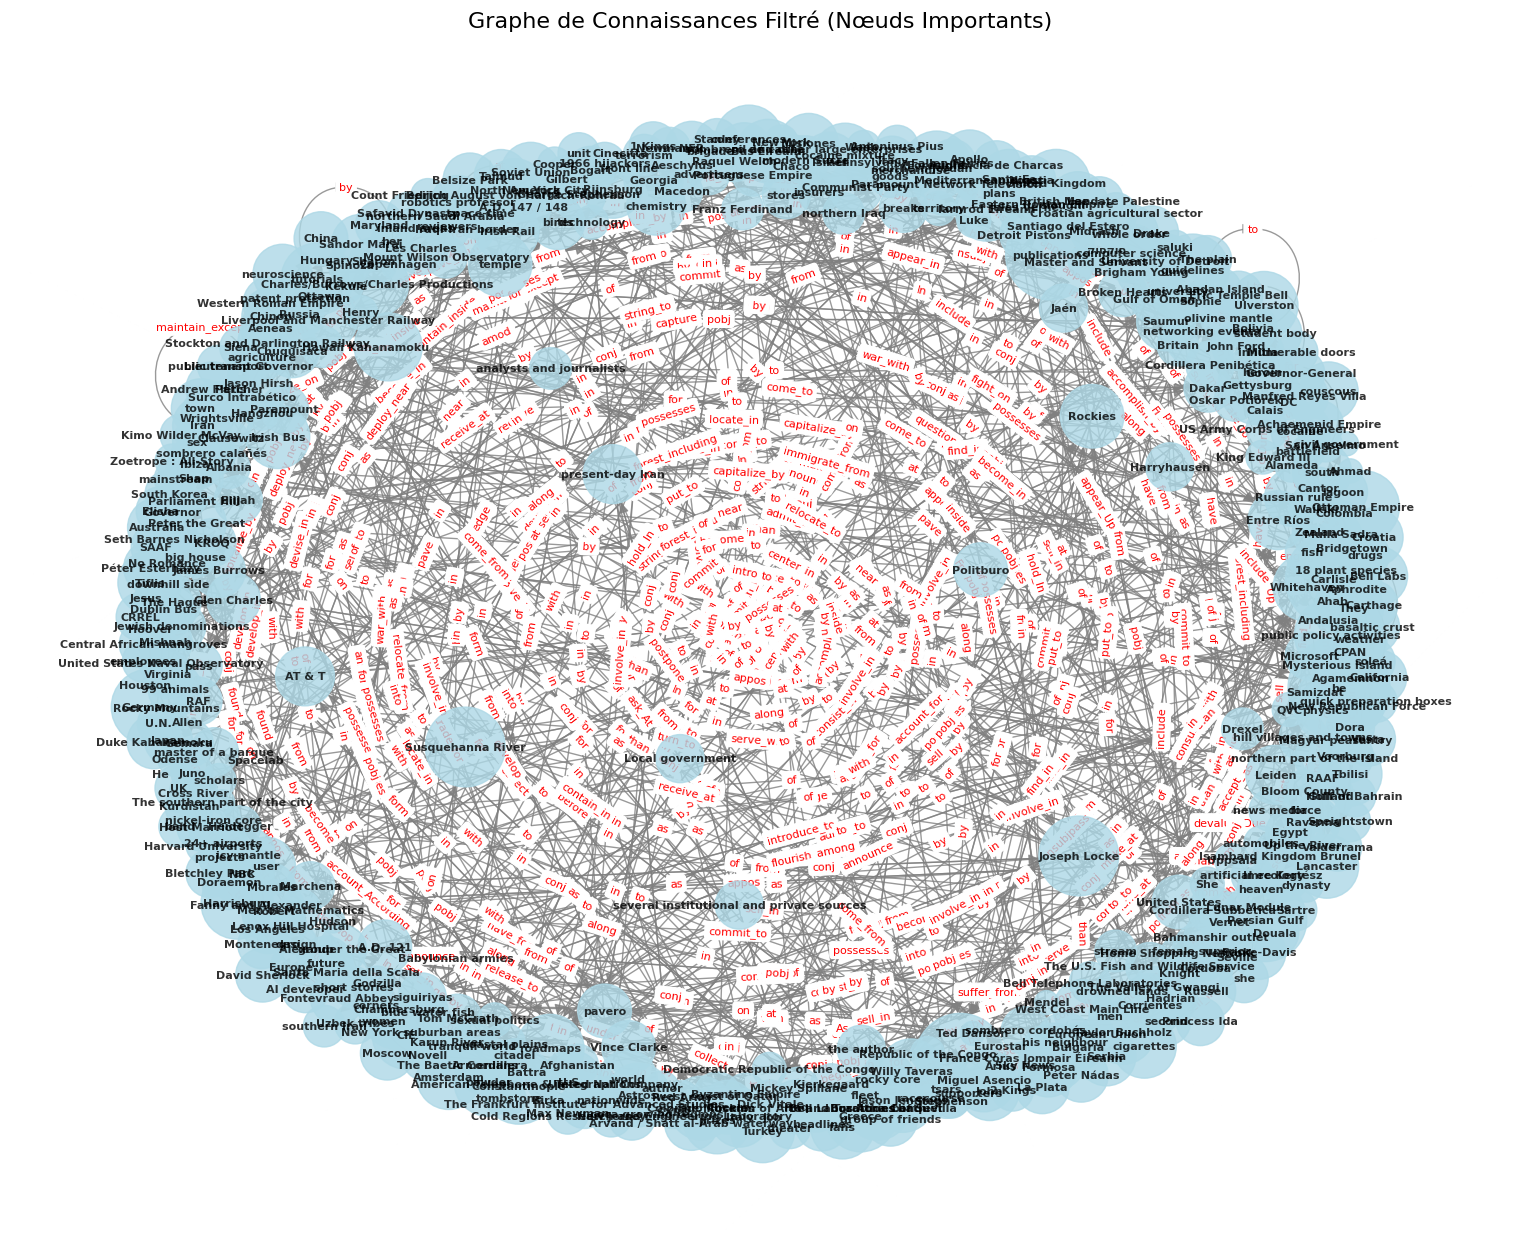

In [44]:
# 4. Visualisation Filtrée (Nœuds Importants)
# Ne garder que les nœuds avec au moins N connexions pour y voir clair
def plotGraph(G, min_degree=3):
        #min_degree = 3
        important_nodes = [node for node, degree in G.degree() if degree >= min_degree]
        G_filtered = G.subgraph(important_nodes)

        print(f"🎯 Sous-graphe filtré (degré >= {min_degree}): {G_filtered.number_of_nodes()} nœuds")

        plt.figure(figsize=(15, 12))
        pos = nx.spring_layout(G_filtered, k=1.5, iterations=50)

        edge_labels = nx.get_edge_attributes(G_filtered, 'relation')

        # Taille des nœuds selon leur importance
        node_sizes = [G_filtered.degree(n) * 300 for n in G_filtered.nodes()]

        nx.draw(G_filtered, pos, 
                with_labels=True, 
                node_color='lightblue', 
                node_size=node_sizes,
                edge_color='gray',
                font_size=8,
                font_weight='bold',
                arrows=True,
                arrowsize=15,
                alpha=0.8)

        nx.draw_networkx_edge_labels(G_filtered, pos, edge_labels=edge_labels, font_color='red', font_size=8)

        plt.title(f"Graphe de Connaissances Filtré (Nœuds Importants)", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

plotGraph(G)


🎯 Sous-graphe filtré (degré >= 7): 77 nœuds


/var/folders/4t/v1dj_3b96158rglkv2ts2g8c0000gn/T/ipykernel_87205/2719571376.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


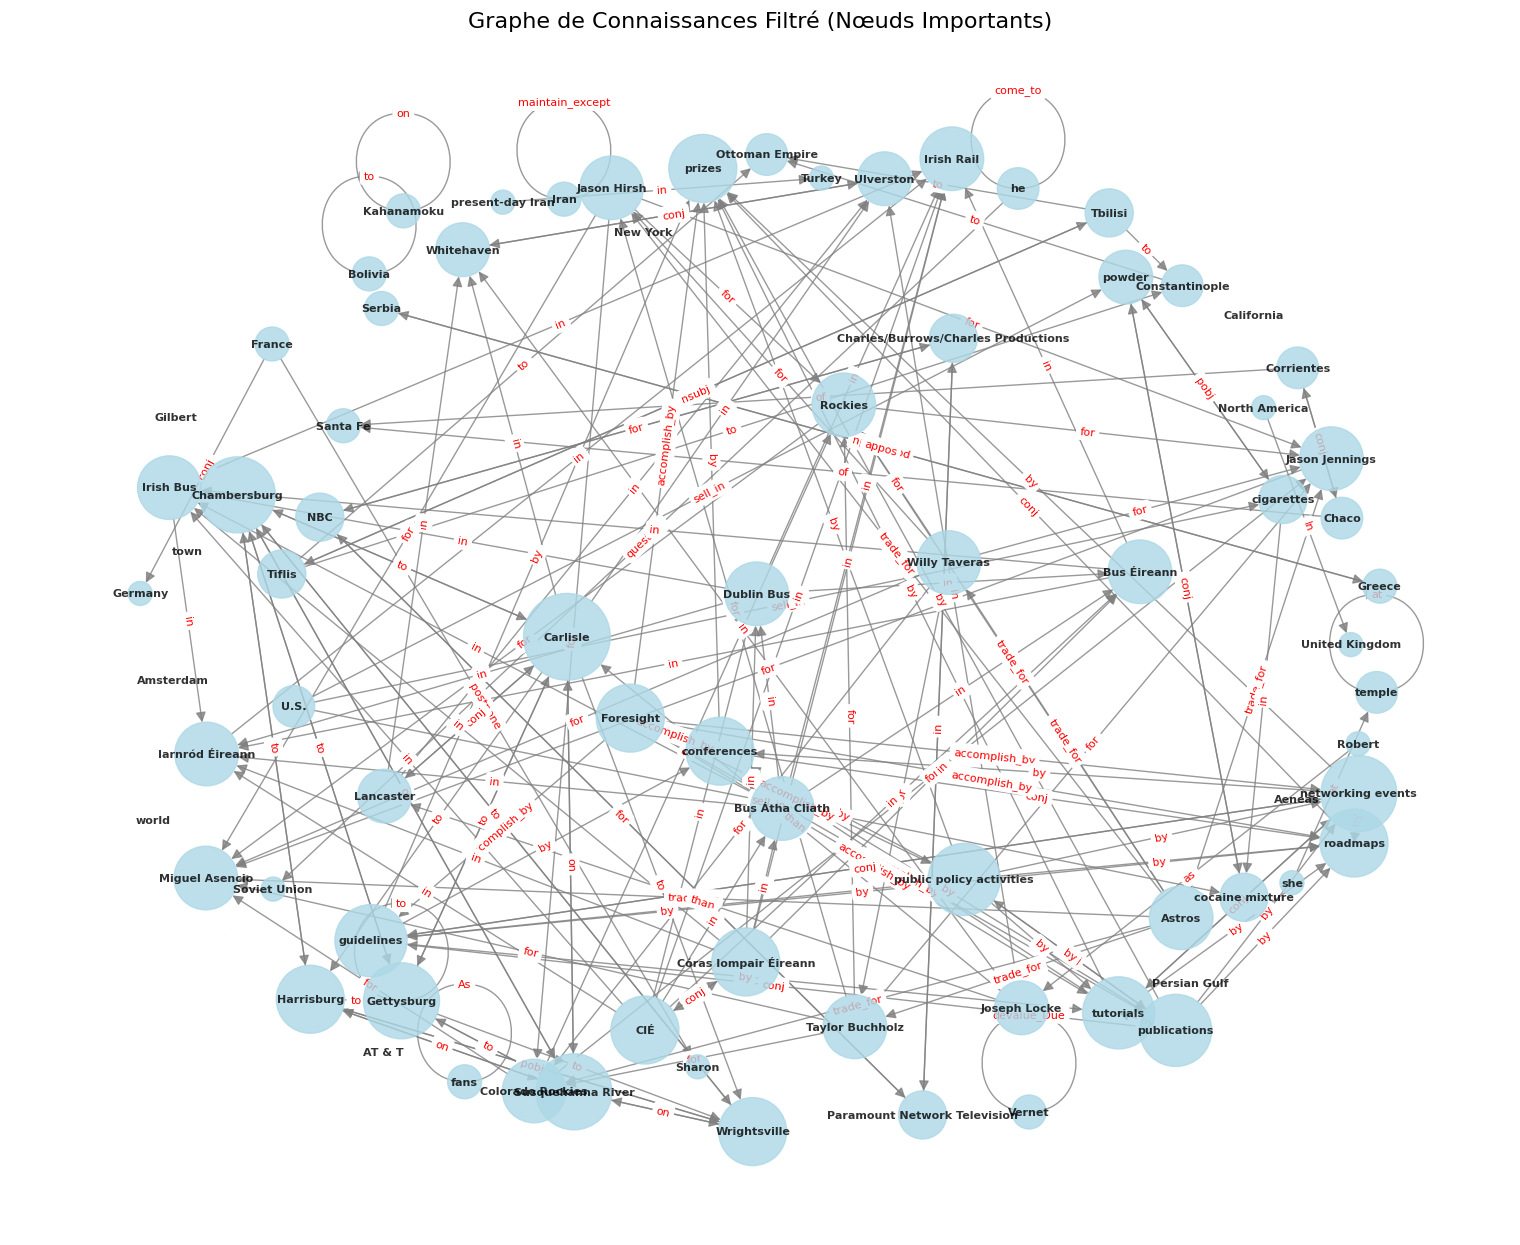

In [49]:
plotGraph(G, min_degree=7)

## ✅ Conclusion

Le système d'extraction de relations a réussi à extraire des triplets sémantiques à partir du dataset.

### 🎯 Résultats Clés
- **1579 triplets** extraits
- **286 types de relations** différentes
- **Moyenne de 2.26 triplets** par phrase

### 📚 Prochaines Étapes
1. Filtrer les triplets par score de confiance
2. Résoudre les coréférences (pronoms)
3. Construire un graphe de connaissances complet
4. Implémenter des requêtes SPARQL

### 📖 Documentation
- `RAPPORT_FINAL_EXTRACTION.md` : Rapport complet de la méthodologie et des résultats
- `README.md` : Vue d'ensemble du projet

## 9️⃣ Visualisation des Communautés

Coloration des nœuds selon leur appartenance aux communautés détectées (Louvain).

🎨 Visualisation du graphe coloré par communautés (690 nœuds affichés)


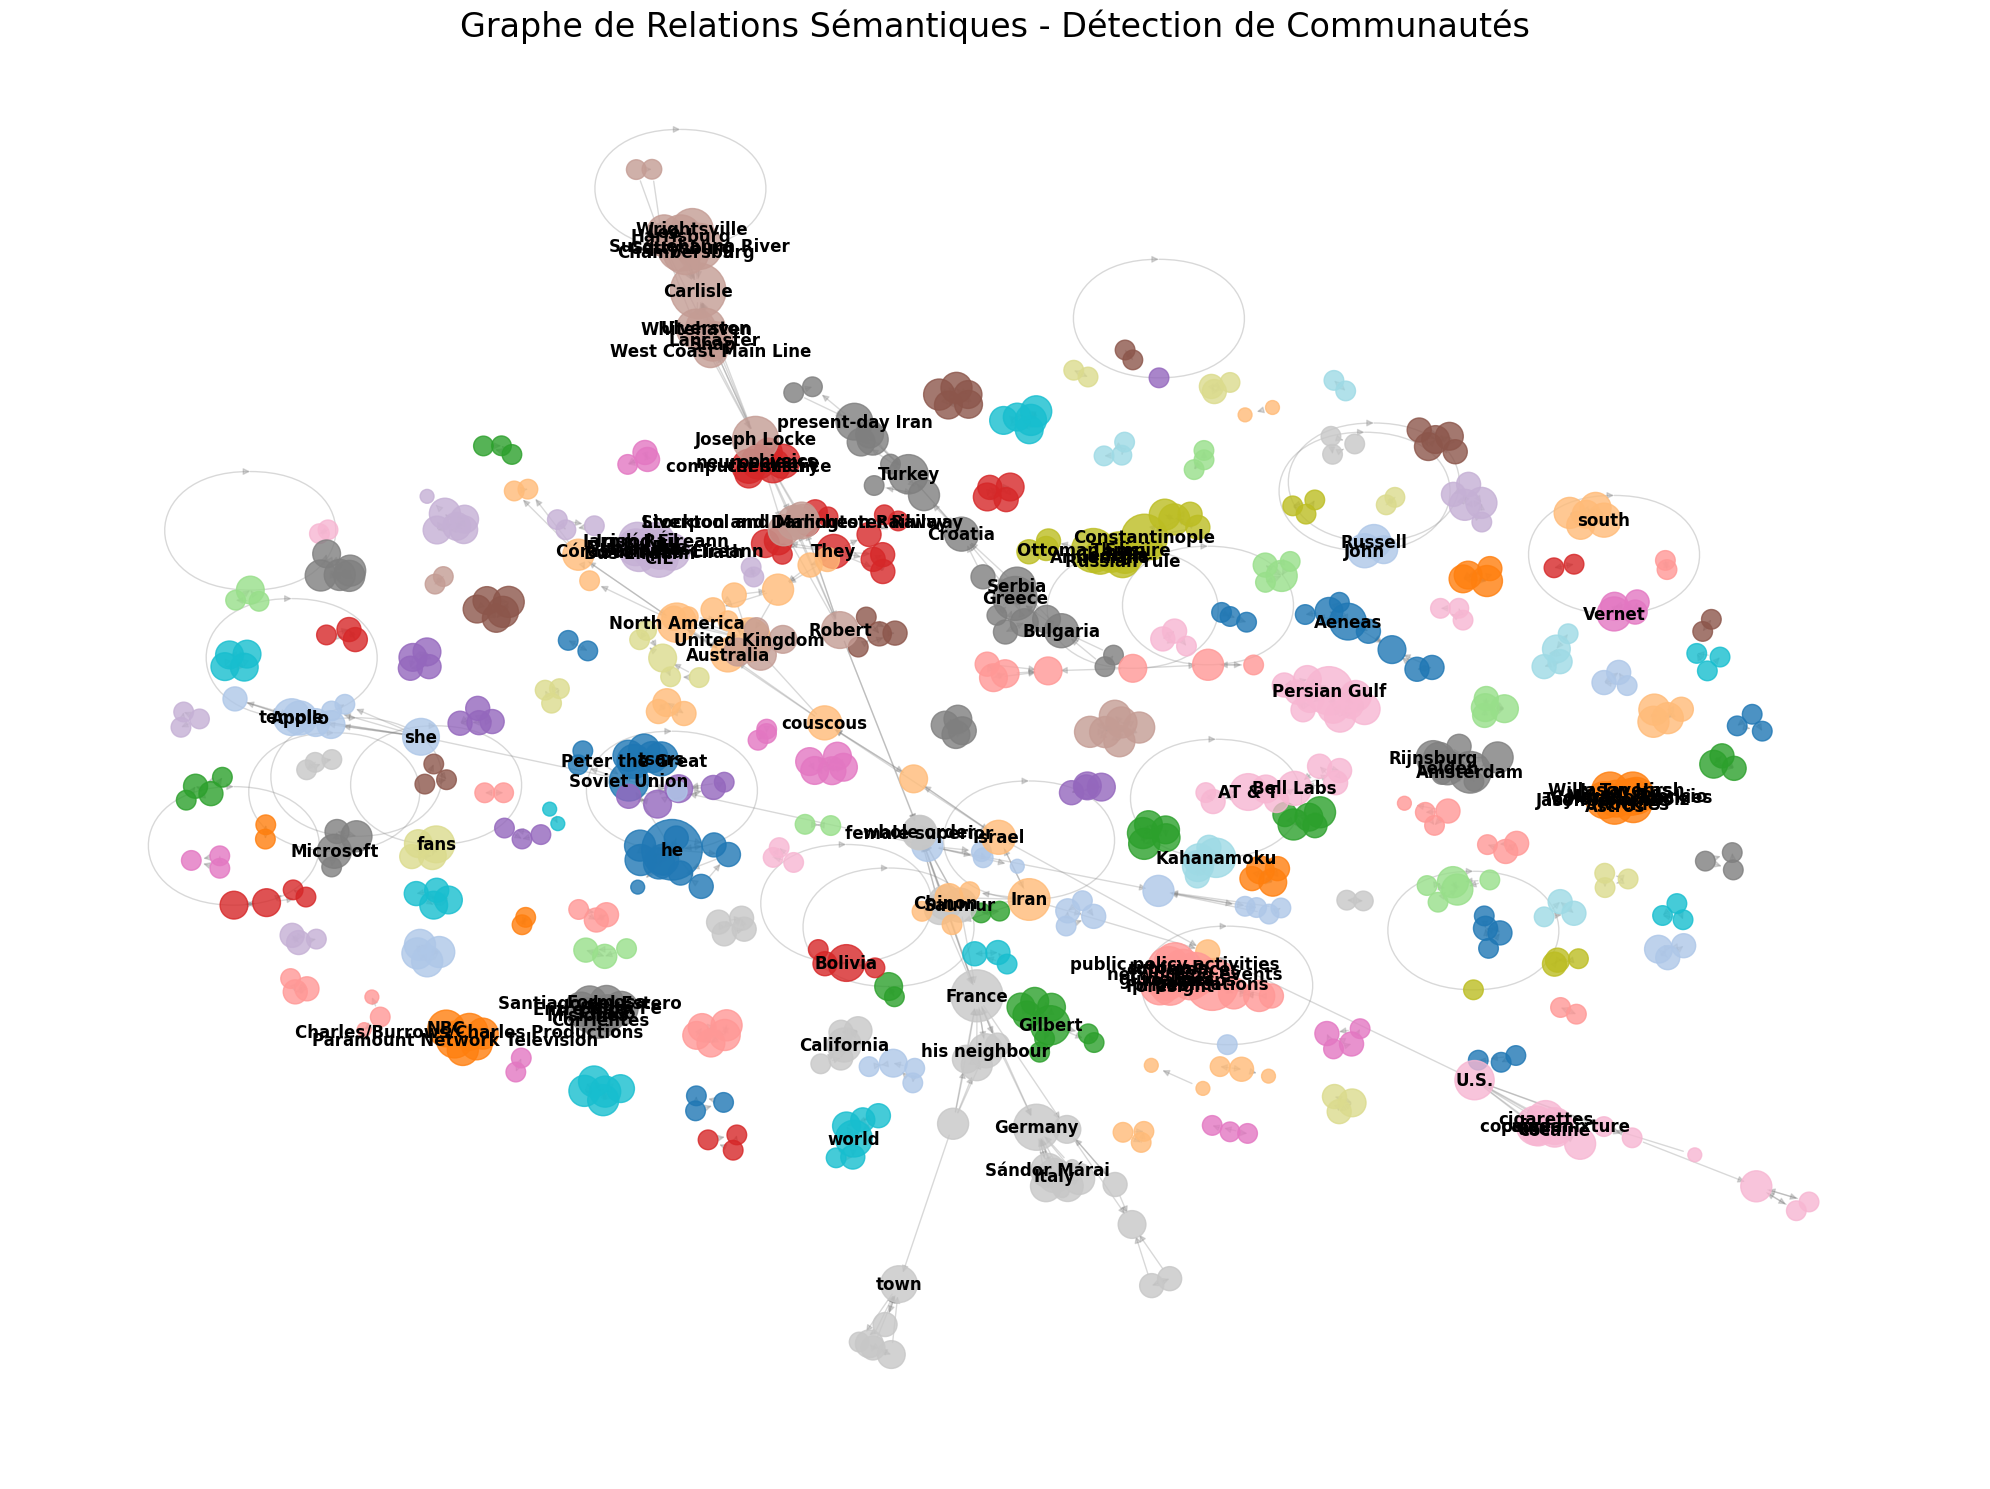

In [47]:
# 9. Visualisation des Communautés
# Affecter une couleur à chaque nœud selon sa communauté
node_to_community = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_to_community[node] = i

# Filtrage pour la lisibilité (degré >= 2)
min_degree = 2
nodes_to_keep = [n for n, d in G.degree() if d >= min_degree]
G_viz = G.subgraph(nodes_to_keep)

# Couleurs et tailles
colors_viz = [node_to_community.get(n, 0) for n in G_viz.nodes()]
sizes_viz = [G_viz.degree(n) * 100 for n in G_viz.nodes()]

print(f"🎨 Visualisation du graphe coloré par communautés ({G_viz.number_of_nodes()} nœuds affichés)")

plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G_viz, k=0.15, iterations=50, seed=42)

# Dessiner les arêtes
nx.draw_networkx_edges(G_viz, pos, alpha=0.3, edge_color='gray')

# Dessiner les nœuds
nx.draw_networkx_nodes(G_viz, pos, 
                       node_color=colors_viz, 
                       cmap=plt.cm.tab20, 
                       node_size=sizes_viz,
                       alpha=0.8)

# Ajouter les labels pour les nœuds importants
labels = {n: n for n in G_viz.nodes() if G_viz.degree(n) > 5}
nx.draw_networkx_labels(G_viz, pos, labels=labels, font_size=12, font_weight="bold")

plt.title("Graphe de Relations Sémantiques - Détection de Communautés", fontsize=24)
plt.axis('off')
plt.tight_layout()
plt.show()

Gérer eppaisseur du trait en fonction de la confiance de la relation, options de formatage du graphique et Formattage de présentation